# [NTDS'18] milestone 3: spectral graph theory
[ntds'18]: https://github.com/mdeff/ntds_2018

[Michaël Defferrard](http://deff.ch), [EPFL LTS2](https://lts2.epfl.ch)

## Students

* Team: `8`
* Students: `Matyas Lustig, Aurélien Pomini, David Salathé, Justine Weber`
* Dataset: `Flight Routes`

## Rules

* Milestones have to be completed by teams. No collaboration between teams is allowed.
* Textual answers shall be short. Typically one to two sentences.
* Code has to be clean.
* You cannot import any other library than we imported.
* When submitting, the notebook is executed and the results are stored. I.e., if you open the notebook again it should show numerical results and plots. We won't be able to execute your notebooks.
* The notebook is re-executed from a blank state before submission. That is to be sure it is reproducible. You can click "Kernel" then "Restart & Run All" in Jupyter.

## Objective

The goal of this milestone is to get familiar with the graph Laplacian and its spectral decomposition.

## 0 Load your network

In [1]:
%matplotlib inline

If you get a `No module named 'sklearn'` error when running the below cell, install [scikit-learn](https://scikit-learn.org) with `conda install scikit-learn` (after activating the `ntds_2018` environment).

In [2]:
import numpy as np
from scipy import sparse
import scipy.sparse.linalg
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

Let's denote your graph as $\mathcal{G} = (\mathcal{V}, \mathcal{E}, A)$, where $\mathcal{V}$ is the set of nodes, $\mathcal{E}$ is the set of edges, $A \in \mathbb{R}^{N \times N}$ is the (weighted) adjacency matrix, and $N = |\mathcal{V}|$ is the number of nodes.

Import the adjacency matrix $A$ that you constructed in the first milestone.
(You're allowed to update it between milestones if you want to.)

In [3]:
# @ALL Should we use the weighted one?
adjacency_uw =  np.load('data/adjacency_sym_mtx_uw.npy')  # the unweighted adjacency matrix
adjacency =  np.load('data/adjacency_sym_mtx.npy')  # the weighted adjacency matrix
n_nodes =  adjacency_uw.shape[0] # the number of nodes in the network
adjacency_uw[np.diag_indices_from(adjacency_uw)] = 0 # set diagonal elements to 0 (see comment)
adjacency[np.diag_indices_from(adjacency)] = 0 # set diagonal elements to 0 (see comment)
n_edges =  adjacency_uw.sum() / 2 # the number of edges in the network

## 1 Graph Laplacian

### Question 1

From the (weighted) adjacency matrix $A$, compute both the combinatorial (also called unnormalized) and the normalized graph Laplacian matrices.

Note: if your graph is weighted, use the weighted adjacency matrix. If not, use the binary adjacency matrix.

For efficient storage and computation, store these sparse matrices in a [compressed sparse row (CSR) format](https://en.wikipedia.org/wiki/Sparse_matrix#Compressed_sparse_row_.28CSR.2C_CRS_or_Yale_format.29).

In [4]:
laplacian_combinatorial =  sparse.csgraph.laplacian(adjacency, normed=False).astype('float64')
laplacian_normalized =  sparse.csgraph.laplacian(adjacency, normed=True)

Use one of them as the graph Laplacian $L$ for the rest of the milestone.
We however encourage you to run the code with both to get a sense of the difference!

In [5]:
laplacian = laplacian_combinatorial
#laplacian = laplacian_normalized

# Either laplacian_combinatorial or laplacian_normalized.

### Question 2

Compute the eigendecomposition of the Laplacian $L = U^\top \Lambda U$, where the columns $u_k \in \mathbb{R}^N$ of $U = [u_1, \dots, u_N] \in \mathbb{R}^{N \times N}$ are the eigenvectors and the diagonal elements $\lambda_k = \Lambda_{kk}$ are the corresponding eigenvalues.

Make sure that the eigenvalues are ordered, i.e., $0 = \lambda_1 \leq \lambda_2 \leq \dots \leq \lambda_N$.

In [6]:
# it is not possible to compute all eigenvalues with sparse.linalg.eigs
#eigenvalues, eigenvectors = sparse.linalg.eigs(laplacian, k = n_nodes-2)

eigenvalues, eigenvectors = scipy.linalg.eigh(laplacian)

print(eigenvalues)
eigenvectors.shape
#eigenvectors =  # Your code here.
#eigenvalues =  # Your code here.

assert eigenvectors.shape == (n_nodes, n_nodes)

[-4.25568274e-15 -4.25568274e-15 -4.25568274e-15 ...  2.40222827e+02
  2.43239875e+02  2.47215876e+02]


In [7]:
idx = 13
u = eigenvectors[:, idx]
c = laplacian.dot(u)

for i in range(3179) :
    a = eigenvalues[i] * u
    if (np.allclose(a,c, 0.000000000000000000000000000000000000000001)) :
        print('TRUE almost equal :', i)    
    if (np.array_equal(a,c)) :
        print('TRUE equal :', i)
    #else :
       # print('FALSE')

TRUE almost equal : 13


Justify your choice of eigensolver.



We will use the fact that our matrix is symmetric and use the scipy.linalg.eigh() function which is designed for this situation.

sparse.linalg.eigs() provides a fast way to get the first k << N eigenvalues of a sparse matrix, using a partial decomposition. However it is not possible to compute all eigenvalues with sparse.linalg.eigs().



### Question 3

We can write $L = S S^\top$. What is the matrix $S$? What does $S^\top x$, with $x \in \mathbb{R}^N$, compute?

Matrix $S$ is the incidence matrix whose elements are equal to $0$ or $\pm 1$. The rows are for nodes and columns for edges. $S(i,j)$ is equal to $+1$ if there is an edge $e_j = (v_i, v_k)$ and equal to $-1$ if there is an edge $e_j = (v_k, v_i)$ for some node $k$, the $0$ is the for other cases.

If there is a signal $x \in \mathbb{R}^N$ then $S^\top x$ computes the gradient of $x$. It is a generalization of the fact that $(S^\top x)[j] = x[i] - x[k]$ is a derivative of $x$ along edge $j$.

### Question 4

Show that $\lambda_k = \| S^\top u_k \|_2^2$, where $\| \cdot \|_2^2$ denotes the squared Euclidean norm (a.k.a. squared $L^2$ norm).

$\| S^\top u_k \|_2^2 =  u_k^\top S S^\top u_k = u_k^\top L u_k$ &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; and while $u_k = D^{-1/2}f_k$ where $D$ is a diagonal degree matrix we can write

$=(D^{-1/2}f_k)^\top L D^{-1/2}f_k$

$=f_k^\top (D^{-1/2})^\top L D^{-1/2}f_k$ &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; as $D$ is diagonal we know that $D=D^\top$ and $L_{norm} = D^{-1/2} L D^{-1/2}$ we can deduce

$=f^\top L_{norm} f_k$

$=\lambda_k$ &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; the desired eigenvalue

What does the quantity $\| S^\top x \|_2^2$ tell us about $x$?

It is a quadratic Dirichlet form, a measure of how smooth a signal $x$ is.

### Question 5

What is the value of $u_0$, both for the combinatorial and normalized Laplacians?

In [8]:
# NOT SURE
eigenvalues_comb, eigenvectors_comb = scipy.linalg.eigh(laplacian_combinatorial)
eigenvalues_norm, eigenvectors_norm = scipy.linalg.eigh(laplacian_normalized)

In [9]:
u0_comb = eigenvectors_comb[:,0]
u0_norm = eigenvectors_norm[:,0]
print("Combinatorial u0 : \n", u0_comb)
print("min (absolute) value : ", np.min(np.absolute(u0_comb)))
print("max (absolute) value : ", np.max(np.absolute(u0_comb)))
print("\nNormalized u0 \n", u0_norm)
print("min (absolute) value : ", np.min(np.absolute(u0_norm)))
print("max (absolute) value : ", np.max(np.absolute(u0_norm)))

Combinatorial u0 : 
 [-0.00182848 -0.00182848 -0.00182848 ... -0.00182848 -0.00182848
 -0.00182848]
min (absolute) value :  0.001828476411040059
max (absolute) value :  0.42269718615977814

Normalized u0 
 [-3.97341103e-07 -5.25632873e-07 -5.96011655e-07 ... -2.80962589e-07
 -1.98670552e-07 -1.98670552e-07]
min (absolute) value :  1.986705513961434e-07
max (absolute) value :  0.6123721833724121


### Question 6

Look at the spectrum of the Laplacian by plotting the eigenvalues.
Comment on what you observe.

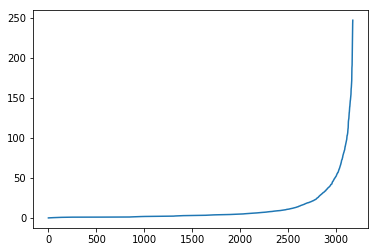

In [10]:
plt.plot(eigenvalues)

**Your answer here.**

We can see that the eigenvalues' values are rising exponentially, an abrupt increase takes place around the last fifth.

//
Null space not that visible... Is something to be said on that point?

How many connected components are there in your graph? Answer using the eigenvalues only.

In [11]:
min_value = eigenvalues[0]

n_components = np.count_nonzero(eigenvalues == min_value)
n_components

7

Is there an upper bound on the eigenvalues, i.e., what is the largest possible eigenvalue? Answer for both the combinatorial and normalized Laplacians.

In [12]:
print(max(eigenvalues_comb))
print(max(eigenvalues_norm))

247.2158761015632
2.0000000000000004


**Your answer here.**
An upper bound exists for the normalized Laplacian eigenvalues and is equal to 2 if and only if we are dealing with a bipartite graph which we can observe in our case.

Our graph is not bipartite. it would be really strange. What we can say is that if the normalized Laplacian has an eigenvalue equal to 2, there exists a *component* of the graph which is bipartite.

## 3 Laplacian eigenmaps

*Laplacian eigenmaps* is a method to embed a graph $\mathcal{G}$ in a $d$-dimensional Euclidean space.
That is, it associates a vector $z_i \in \mathbb{R}^d$ to every node $v_i \in \mathcal{V}$.
The graph $\mathcal{G}$ is thus embedded as $Z \in \mathbb{R}^{N \times d}$.

In [13]:
import networkx as nx
G = nx.from_numpy_matrix(adjacency)
Gc = max(nx.connected_component_subgraphs(G), key=len)
adjacency_c = np.array(nx.to_numpy_matrix(Gc))
n_nodes_c = nx.number_of_nodes(Gc)
laplacian_c_comb = sparse.csgraph.laplacian(adjacency_c, normed=False).astype('float64')
laplacian_c_norm = sparse.csgraph.laplacian(adjacency_c, normed=True)
laplacian_c = laplacian_c_comb

### Question 7

What do we use Laplacian eigenmaps for? (Or more generally, graph embeddings.)

Graph embeddings map networks, graphs into a vector space preserving relevant network properties. Laplacian eigenmaps produce coordinate maps that are smooth functions over the original graph. That alows us to reduce the possible dimensions of each of the graph data point based on their similarity. Which is useful for making any computations less demanding and clearer visualization of the problem.

On some problems, our data points are living in a lower-dimensional manifold than the actual dimension space. Laplacian eigenmaps is a "non-linear dimensionality reduction", which means that it can reduce an "S-shape" or a "Swiss roll" living in a 3 (or greater) dimension back on a lower (e.g. two) dimensions space by conserving connectiveness property. (which would not be possible with a linear dimensionality reduction algorithm). The purpose of this technique is to reduce our dimensional problem onto a lower dimension, which can improve efficiency of some computations (eg in machine learning).

### Question 8

Embed your graph in $d=2$ dimensions with Laplacian eigenmaps.
Try with and without re-normalizing the eigenvectors by the degrees, then keep the one your prefer.

**Recompute** the eigenvectors you need with a partial eigendecomposition method for sparse matrices.
When $k \ll N$ eigenvectors are needed, partial eigendecompositions are much more efficient than complete eigendecompositions.
A partial eigendecomposition scales as $\Omega(k |\mathcal{E}|$), while a complete eigendecomposition costs $\mathcal{O}(N^3)$ operations.

In [14]:
# From assistant ?? 
k_eig_val, k_eig_vect = scipy.sparse.linalg.eigsh(laplacian_c_norm, k=3, which='SM') # which = largest eigen values -> change ?
eigen_map = k_eig_vect[:,[1,2]]
print(eigen_map)

[[ 0.00169202 -0.00237129]
 [ 0.00224734 -0.00315625]
 [ 0.00254976 -0.003583  ]
 ...
 [ 0.00144841 -0.0015425 ]
 [ 0.00069985 -0.00057041]
 [ 0.00071297 -0.00067753]]


Plot the nodes embedded in 2D. Comment on what you see.

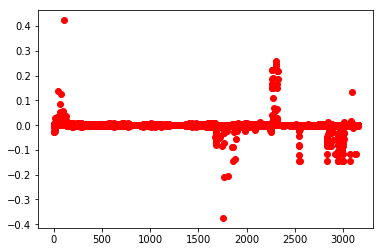

In [20]:
plt.plot(eigen_map, 'ro')

**Your answer here.**

### Question 9

What does the embedding $Z \in \mathbb{R}^{N \times d}$ preserve?

In this case $Z$ is the large data matrix, $N$ is the number of data points and $d$ the dimension of each of the data points which we want to reduce. The embeding preserves the relevant network properties, the number of nodes.

**not sure..**

The embedding Z preserves the number of nodes, but it also preserves the *connectiveness* of the nodes, i.e. how components were connected.

## 2 Spectral clustering

*Spectral clustering* is a method to partition a graph into distinct clusters.
The method associates a feature vector $z_i \in \mathbb{R}^d$ to every node $v_i \in \mathcal{V}$, then runs [$k$-means](https://en.wikipedia.org/wiki/K-means_clustering) in the embedding space $\mathbb{R}^d$ to assign each node $v_i \in \mathcal{V}$ to a cluster $c_j \in \mathcal{C}$, where $k = |\mathcal{C}|$ is the number of desired clusters.

### Question 10

Choose $k$ and $d$. How did you get to those numbers?

We can pick k (8) as the number of connected components + 1 (the trivial one). The dimension is just the size of a row (or column) of our adjacency matrix, i.e. it is just the number of nodes

### Question 11

1. Embed your graph in $\mathbb{R}^d$ as $Z \in \mathbb{R}^{N \times d}$.
   Try with and without re-normalizing the eigenvectors by the degrees, then keep the one your prefer.
1. If you want $k=2$ clusters, partition with the Fiedler vector. For $k > 2$ clusters, run $k$-means on $Z$. Don't implement $k$-means, use the `KMeans` class imported from scikit-learn.

In [16]:
k_eig_val, k_eig_vect = scipy.sparse.linalg.eigsh(laplacian_c_norm, k=8, which='SM')
# Normalizing by the degree
diag = np.diag(laplacian_c_norm)
for i in range(8):
    k_eig_vect[:, i] /= diag
Z = np.array(KMeans(n_clusters=8, random_state=0).fit_predict(k_eig_vect))


### Question 12

Use the computed cluster assignment to reorder the adjacency matrix $A$.
What do you expect? What do you observe?

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


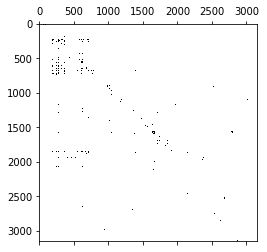

In [17]:
ordered_adj = np.zeros((n_nodes_c, n_nodes_c))
last_idx = 0
for i in range(8):
    ordered_adji = adjacency_c[Z==i]
    size = ordered_adji.shape[0]
    ordered_adj[last_idx:last_idx+size] = ordered_adji
    last_idx += size
    
print(ordered_adj)
plt.spy(ordered_adj)
    

I guess we would end up with smthg like [1,1,1, 0,0,0,  0,0,0] [0,0,0, 1,1,1, 0,0,0]...

### Question 13

If you have ground truth clusters for your dataset, compare the cluster assignment from spectral clustering to the ground truth.
A simple quantitative measure is to compute the percentage of nodes that have been correctly categorized.
If you don't have a ground truth, qualitatively assess the quality of the clustering.

Ground truth clusters are the "real clusters".
For example, the genre of musical tracks in FMA, the category of Wikipedia articles, the spammer status of individuals, etc.
Look for the `labels` in the [dataset descriptions](https://github.com/mdeff/ntds_2018/tree/master/projects/README.md).

In [18]:
# Your code here. Lol no idea

### Question 14

Plot the cluster assignment (one color per cluster) on the 2D embedding you computed above with Laplacian eigenmaps.

In [19]:
# Your code here.

### Question 15

Why did we use the eigenvectors of the graph Laplacian as features? Could we use other features for clustering?

**Your answer here.**
The eigenvectors of the graph Laplacian are a good approximation of how much data we have on some axis. Eigenvalues tell us how much close are our information and eigenvectors how can we use new axis to better describe them. Hence it is a good metric to reduce dimension of our data space.
Yes of course there is plenty of manners to cluster our graph. We could use features of lattitude and longitude to work with metric distances and to use that instead for clustering points between them, regardless their connectivity, ie their routes.